# 00 - Introduction: Estimand-First OPE

This notebook is a fast, narrative tour of CausalRL. The key idea is
estimand-first OPE: you declare the estimand and its assumptions, then every
estimator and report is obligated to surface diagnostics that tell you whether
the assumptions look plausible in the data.

We run a small synthetic bandit experiment (so we know ground truth), inspect
the report schema, and export a self-contained HTML report. Along the way we
touch the public APIs for policies, data contracts, benchmarks, and
experiment runners.

## Setup

Suggested environment:

```
pip install "causalrl[plots]"
```

(You can add `[docs]` or `[notebooks]` if you want full notebook tooling.)

In [1]:
from __future__ import annotations

from pathlib import Path

import numpy as np
import pandas as pd
import yaml

import crl
from crl.benchmarks.bandit_synth import SyntheticBandit, SyntheticBanditConfig
from crl.benchmarks.harness import (
    run_all_benchmarks,
    run_bandit_benchmark,
    run_mdp_benchmark,
)
from crl.benchmarks.mdp_synth import SyntheticMDP, SyntheticMDPConfig
from crl.data import (
    BanditDataset,
    LoggedBanditDataset,
    TrajectoryDataset,
    TransitionDataset,
)
from crl.experiments import run_benchmark_suite, run_benchmarks_to_table
from crl.ope import OpeReport, evaluate
from crl.policies import (
    BehaviorPolicy,
    MLPConfig,
    Policy,
    StochasticPolicy,
    TabularPolicy,
    TorchMLPPolicy,
    UniformPolicy,
)
from crl.utils.seeding import set_seed
from crl.utils.validation import (
    require_finite,
    require_in_unit_interval,
    require_ndarray,
    require_same_length,
    require_shape,
)
from crl.viz import configure_notebook_display

In [2]:
set_seed(0)
np.random.seed(0)
configure_notebook_display()

print("crl", crl.__version__)

crl 0.1.0


## Synthetic data for the tour

We use the built-in synthetic bandit benchmark as a common source of logged
data for policy and estimator demos.

In [3]:
benchmark = SyntheticBandit(SyntheticBanditConfig(seed=0))
dataset = benchmark.sample(num_samples=1_000, seed=1)
true_value = benchmark.true_policy_value(benchmark.target_policy)

pd.DataFrame([dataset.describe()])

,type,num_samples,context_dim,action_space_n,behavior_action_probs_present,reward_mean,reward_std,reward_min,reward_max,behavior_prob_min,behavior_prob_max
0,bandit,1000,1,4,True,-0.222793,1.136133,-2.608108,1.674282,0.10972,0.570458


## Policy interfaces

Policies expose action probabilities, log-probabilities, and sampling. Below
we create uniform, stochastic, tabular, torch-backed, and behavior policy
wrappers and display a snapshot of their action probabilities.

In [4]:
rng = np.random.default_rng(0)
sample_contexts = dataset.contexts[:6]

uniform_policy = UniformPolicy(action_space_n=dataset.action_space_n)


def softmax_probs(obs: np.ndarray) -> np.ndarray:
    obs = np.asarray(obs)
    obs_2d = obs if obs.ndim == 2 else obs.reshape(-1, 1)
    logits = np.zeros((obs_2d.shape[0], dataset.action_space_n), dtype=float)
    logits[:, 0] = obs_2d[:, 0]
    if dataset.action_space_n > 1:
        logits[:, 1] = -obs_2d[:, 0]
    exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
    return exp_logits / exp_logits.sum(axis=1, keepdims=True)


stochastic_policy = StochasticPolicy(
    prob_fn=softmax_probs, action_space_n=dataset.action_space_n, name="softmax_demo"
)

# Tabular policies require discrete state indices.
# We use a tiny two-state example to illustrate the interface.
tabular_policy = TabularPolicy(np.array([[0.7, 0.3], [0.2, 0.8]]))
tabular_states = np.array([0, 1, 0, 1, 1])

mlp_policy = TorchMLPPolicy.from_config(
    MLPConfig(
        input_dim=sample_contexts.shape[1] if sample_contexts.ndim > 1 else 1,
        action_dim=dataset.action_space_n,
        hidden_sizes=(16, 16),
        activation="tanh",
    )
)

behavior_policy = BehaviorPolicy(
    policy=uniform_policy, source="known", diagnostics={"note": "demo"}
)

sample_actions = uniform_policy.sample_action(sample_contexts[:4], rng)
log_probs = uniform_policy.log_prob(sample_contexts[:4], sample_actions)

policy_rows = [
    {
        "policy": "uniform",
        "sample_probs": uniform_policy.action_probs(sample_contexts[:1])[0],
    },
    {
        "policy": "stochastic",
        "sample_probs": stochastic_policy.action_probs(sample_contexts[:1])[0],
    },
    {
        "policy": "tabular",
        "sample_probs": tabular_policy.action_probs(tabular_states[:1])[0],
    },
    {
        "policy": "torch_mlp",
        "sample_probs": mlp_policy.action_probs(sample_contexts[:1])[0],
    },
]

pd.DataFrame(policy_rows), behavior_policy.to_dict(), log_probs[:3]

(       policy                                       sample_probs
 0     uniform                           [0.25, 0.25, 0.25, 0.25]
 1  stochastic  [0.5344466453885229, 0.07232948812851327, 0.19...
 2     tabular                                         [0.7, 0.3]
 3   torch_mlp    [0.3297096, 0.28284377, 0.12580189, 0.26164475],
 {'policy_type': 'BehaviorPolicy',
  'source': 'known',
  'wrapped': 'UniformPolicy',
  'diagnostics': {'note': 'demo'},
  'metadata': {}},
 array([-1.38629436, -1.38629436, -1.38629436]))

In [5]:
isinstance(uniform_policy, Policy)

True

## Data contracts and validation helpers

CausalRL ships data classes for logged bandits, trajectories, and transitions.
We also provide validation helpers for shapes and probability bounds.

In [6]:
manual_contexts = np.random.normal(size=(6, 2))
manual_actions = np.array([0, 1, 0, 1, 0, 1])
manual_rewards = np.random.normal(size=6)
manual_behavior_probs = np.full(6, 0.5)

require_ndarray("contexts", manual_contexts)
require_shape("actions", manual_actions, 1)
require_same_length(
    ["contexts", "actions", "rewards"],
    [manual_contexts, manual_actions, manual_rewards],
)
require_finite("rewards", manual_rewards)
require_in_unit_interval("behavior_action_probs", manual_behavior_probs)

manual_dataset = LoggedBanditDataset(
    contexts=manual_contexts,
    actions=manual_actions,
    rewards=manual_rewards,
    behavior_action_probs=manual_behavior_probs,
    action_space_n=2,
    metadata={"source": "manual_demo"},
)

roundtrip = LoggedBanditDataset.from_dict(manual_dataset.to_dict())

pd.DataFrame([roundtrip.describe()]), isinstance(roundtrip, BanditDataset)

(     type  num_samples  context_dim  action_space_n  \
 0  bandit            6            2               2   
 
    behavior_action_probs_present  reward_mean  reward_std  reward_min  \
 0                           True     0.491529    0.536516   -0.205158   
 
    reward_max  behavior_prob_min  behavior_prob_max  
 0    1.494079                0.5                0.5  ,
 True)

In [7]:
mdp_benchmark = SyntheticMDP(SyntheticMDPConfig(seed=5, horizon=4))
traj_dataset = mdp_benchmark.sample(num_trajectories=5, seed=6)

mask_flat = traj_dataset.mask.reshape(-1)
obs_flat = traj_dataset.observations.reshape(
    -1, *traj_dataset.observations.shape[2:]
)[mask_flat]
next_obs_flat = traj_dataset.next_observations.reshape(
    -1, *traj_dataset.next_observations.shape[2:]
)[mask_flat]
actions_flat = traj_dataset.actions.reshape(-1)[mask_flat]
rewards_flat = traj_dataset.rewards.reshape(-1)[mask_flat]
dones_flat = traj_dataset.dones.reshape(-1)[mask_flat]
behavior_probs_flat = (
    traj_dataset.behavior_action_probs.reshape(-1)[mask_flat]
    if traj_dataset.behavior_action_probs is not None
    else None
)

episode_ids = np.repeat(
    np.arange(traj_dataset.num_trajectories), traj_dataset.horizon
)[mask_flat]
timesteps = np.tile(np.arange(traj_dataset.horizon), traj_dataset.num_trajectories)[
    mask_flat
]

transition_dataset = TransitionDataset(
    states=obs_flat,
    actions=actions_flat,
    rewards=rewards_flat,
    next_states=next_obs_flat,
    dones=dones_flat,
    behavior_action_probs=behavior_probs_flat,
    discount=traj_dataset.discount,
    action_space_n=traj_dataset.action_space_n,
    episode_ids=episode_ids,
    timesteps=timesteps,
    metadata={"source": "flattened_from_trajectory"},
)

trajectory_roundtrip = transition_dataset.to_trajectory()

(
    pd.DataFrame([transition_dataset.describe()]),
    pd.DataFrame([trajectory_roundtrip.describe()]),
    isinstance(trajectory_roundtrip, TrajectoryDataset),
)

(         type  num_steps  discount  action_space_n  \
 0  transition         20      0.95               3   
 
    behavior_action_probs_present  episode_ids_present  timesteps_present  \
 0                           True                 True               True   
 
    done_fraction  reward_mean  reward_std  reward_min  reward_max  \
 0           0.25     0.073457    0.913016   -1.073053    1.911154   
 
    behavior_prob_min  behavior_prob_max  
 0           0.038967           0.795979  ,
          type  num_trajectories  horizon  num_steps  discount  action_space_n  \
 0  trajectory                 5        4         20      0.95               3   
 
    state_space_n  observation_dim  behavior_action_probs_present  \
 0              6                1                           True   
 
    trajectory_length_min  trajectory_length_max  trajectory_length_mean  \
 0                      4                      4                     4.0   
 
    reward_mean  reward_std  reward_min  re

## Quick OPE run

We evaluate a target policy and compare estimators in a single call. The
resulting report is a structured object that can serialize to a DataFrame or
HTML.

In [8]:
report = evaluate(dataset=dataset, policy=benchmark.target_policy)
report.summary_table(), isinstance(report, OpeReport)

(      value    stderr                                           ci  \
 0 -0.393095  0.038707   (-0.4689586418751796, -0.3172317897744404)   
 1 -0.396854  0.042185  (-0.4795340623004983, -0.31417340185074777)   
 2 -0.423104  0.030082   (-0.4820637874360876, -0.3641436844986299)   
 
                                          diagnostics  \
 0  {'overlap': {'min_behavior_prob': 0.1097201314...   
 1  {'overlap': {'min_behavior_prob': 0.1097201314...   
 2  {'overlap': {'min_behavior_prob': 0.1097201314...   
 
                   assumptions_checked assumptions_flagged warnings  \
 0  [sequential_ignorability, overlap]                  []       []   
 1  [sequential_ignorability, overlap]                  []       []   
 2  [sequential_ignorability, overlap]                  []       []   
 
                                             metadata  lower_bound  \
 0  {'estimator': 'IS', 'num_samples': 1000, 'requ...    -0.468959   
 1  {'estimator': 'WIS', 'num_samples': 1000, 'req...    -

In [9]:
from crl.core import EstimationReport

first_report = next(iter(report.reports.values()))
isinstance(first_report, EstimationReport)

True

## Visualization helpers

OpeReport includes convenience plotting methods for estimator comparisons and
weight diagnostics.

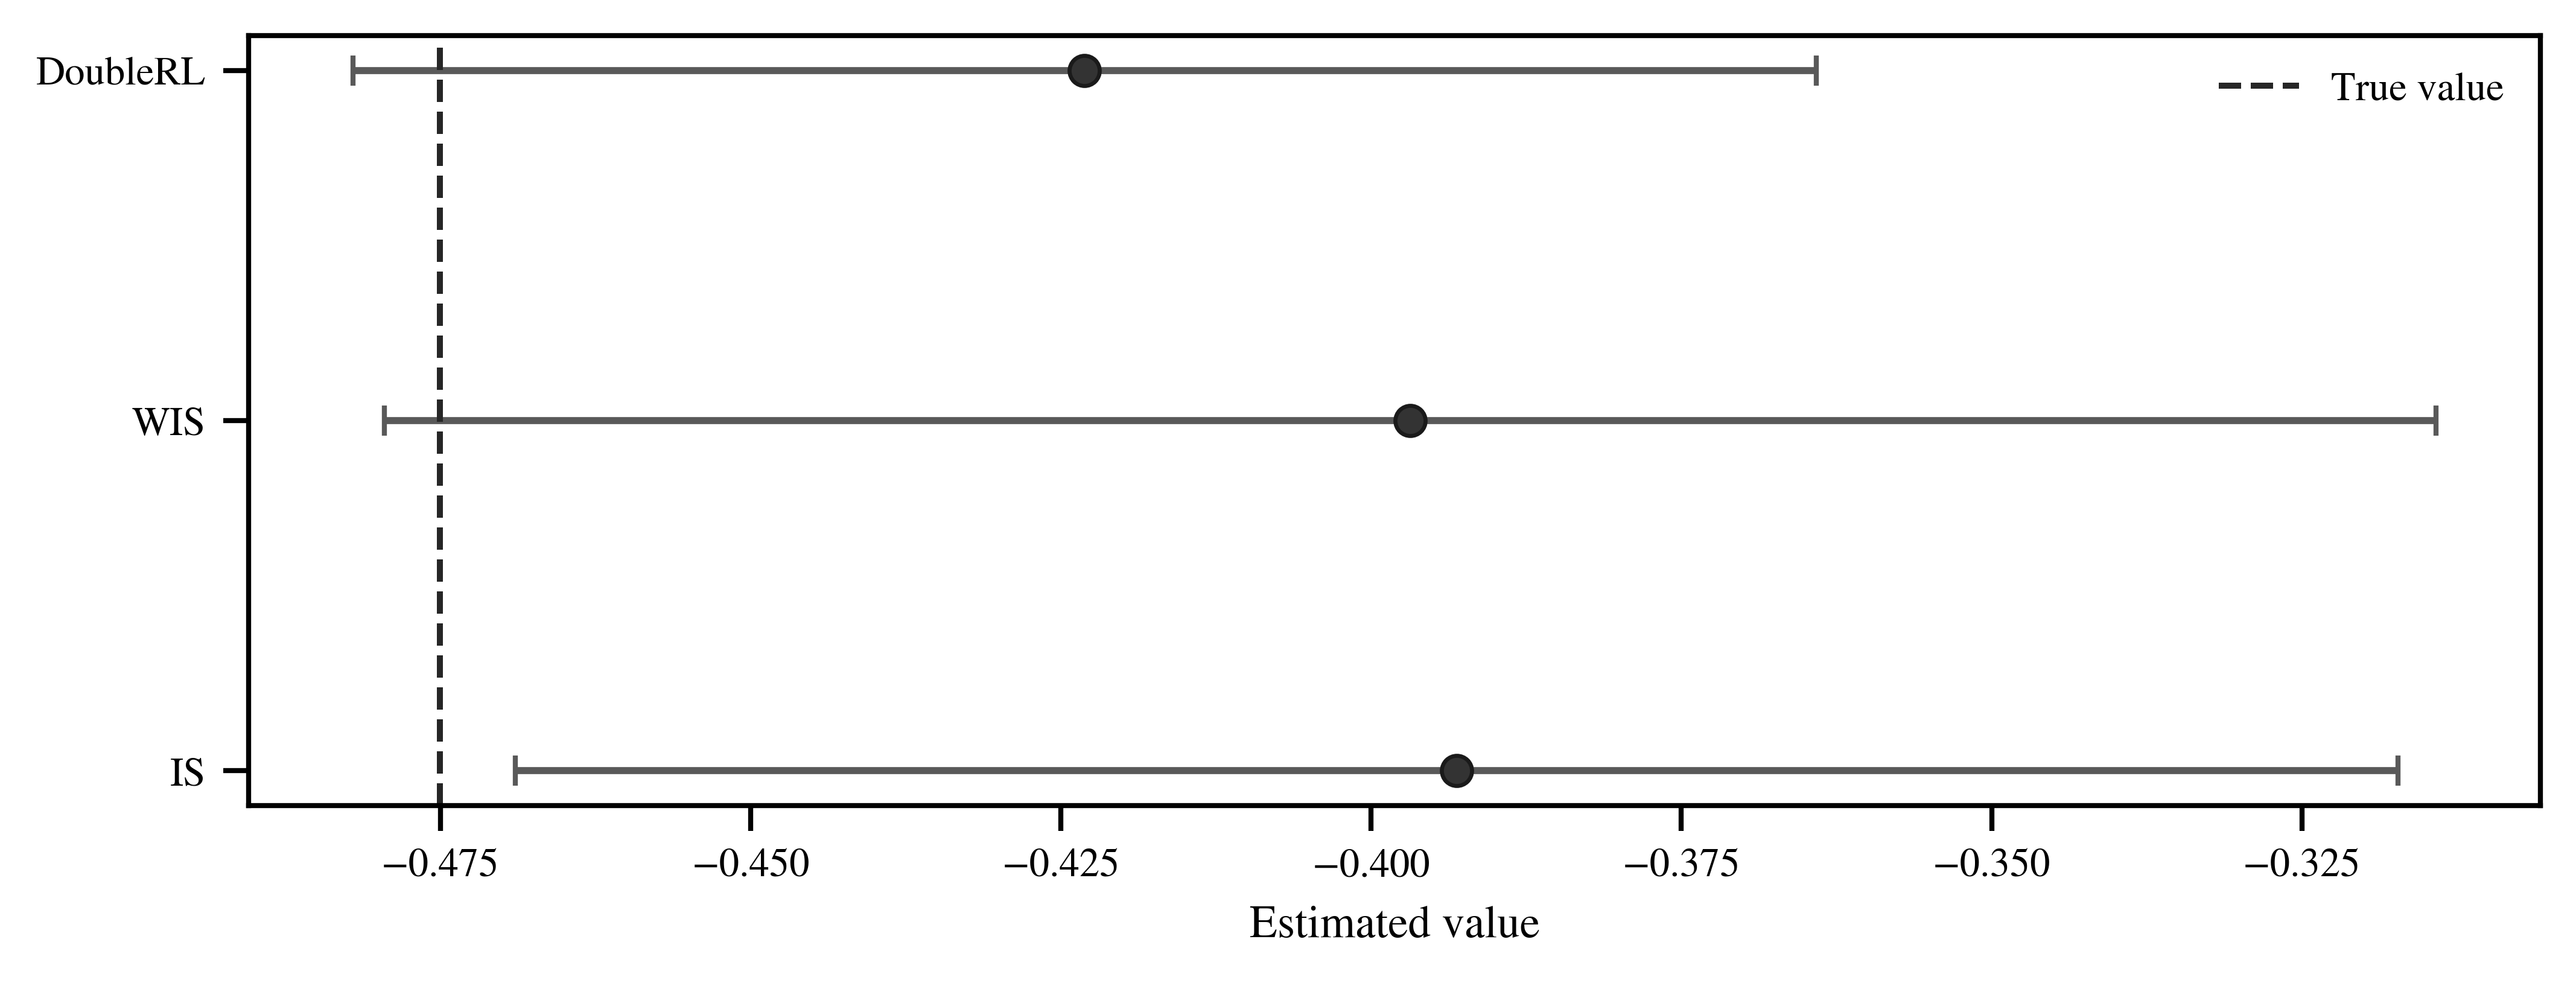

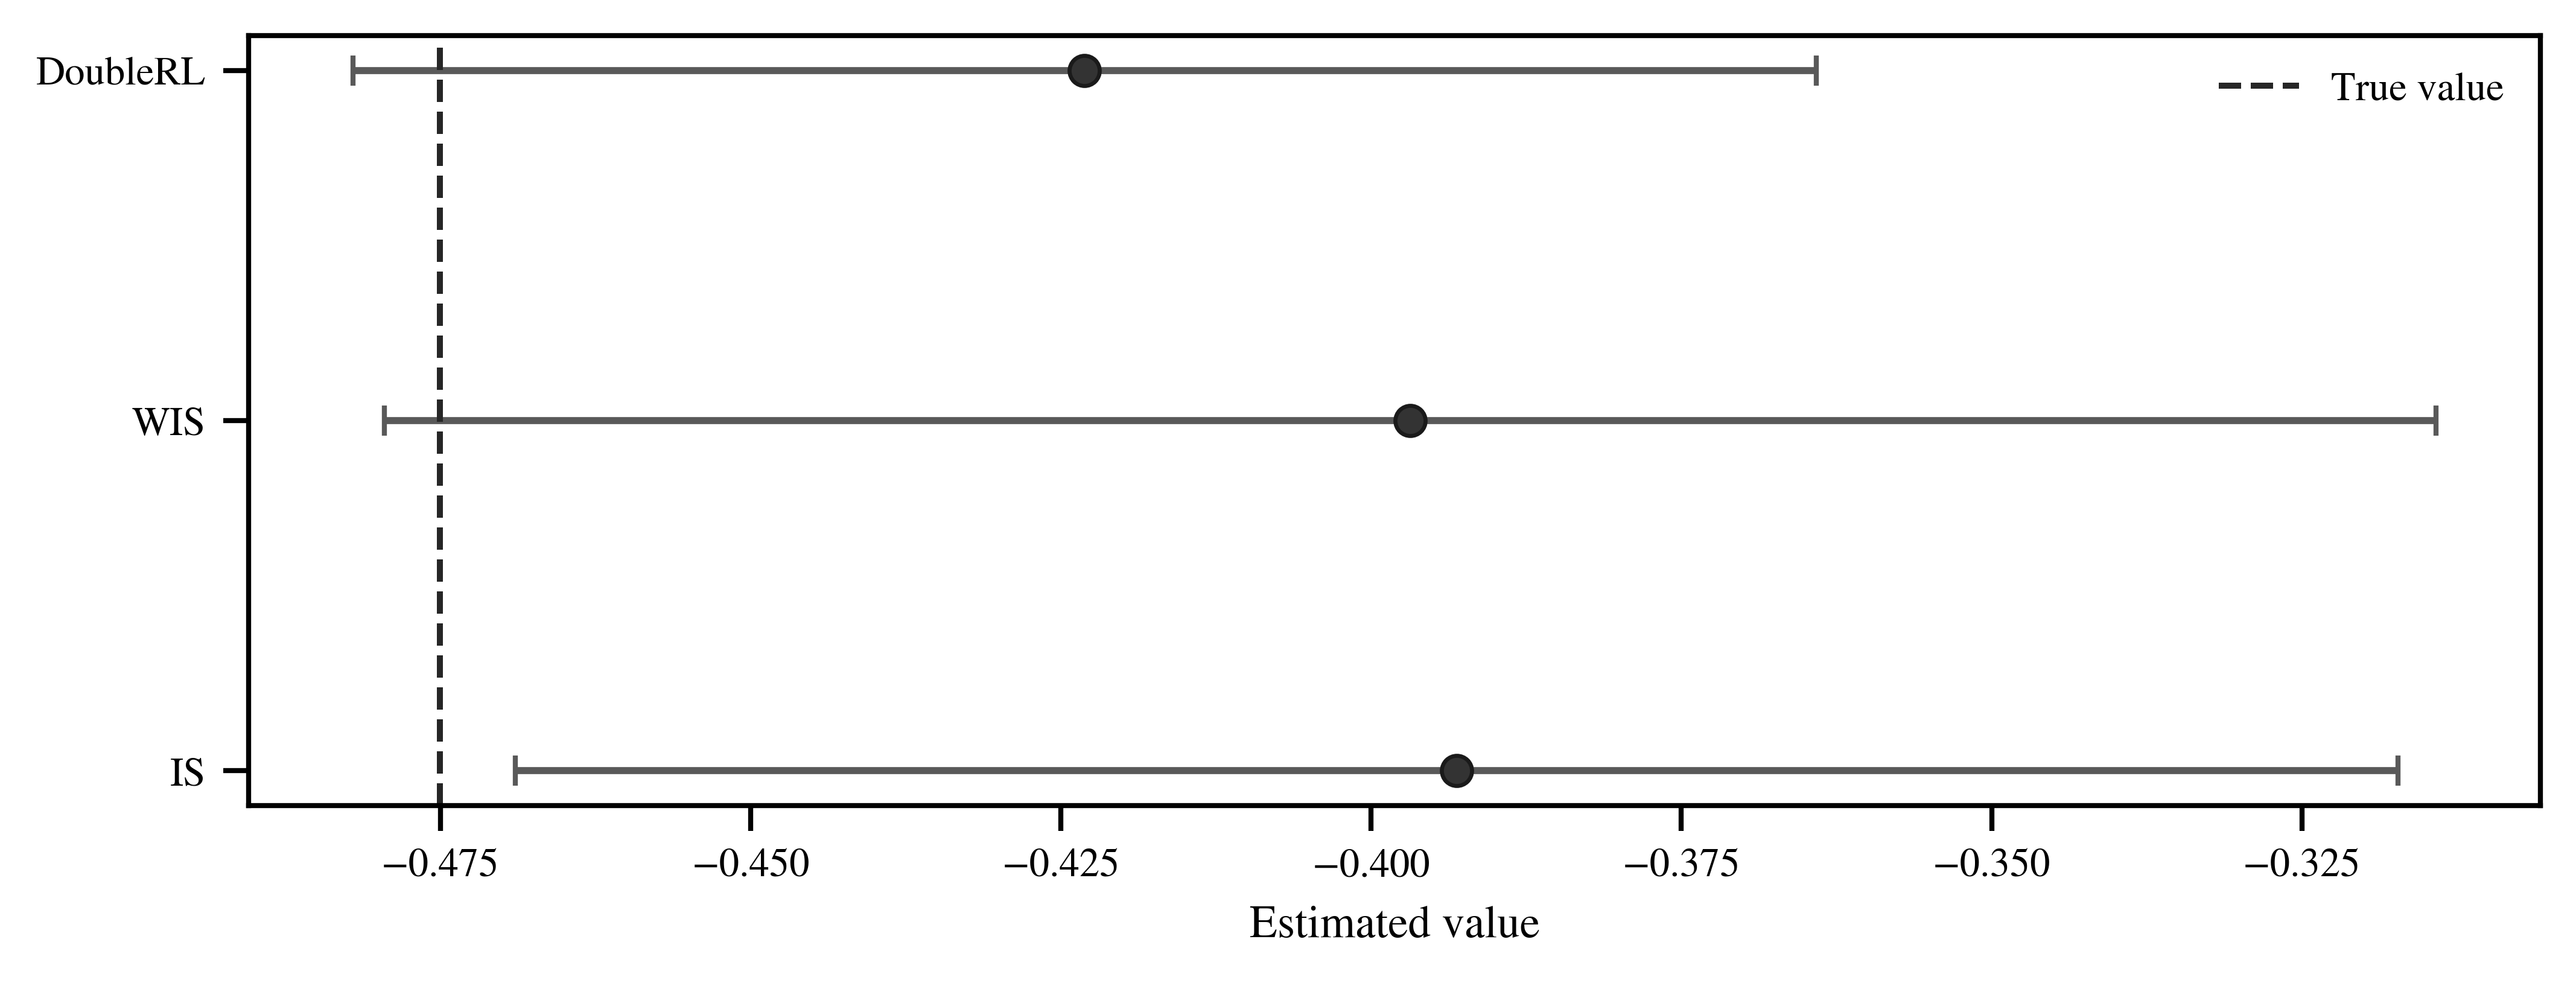

In [10]:
fig_comparison = report.plot_estimator_comparison(truth=true_value)
fig_comparison

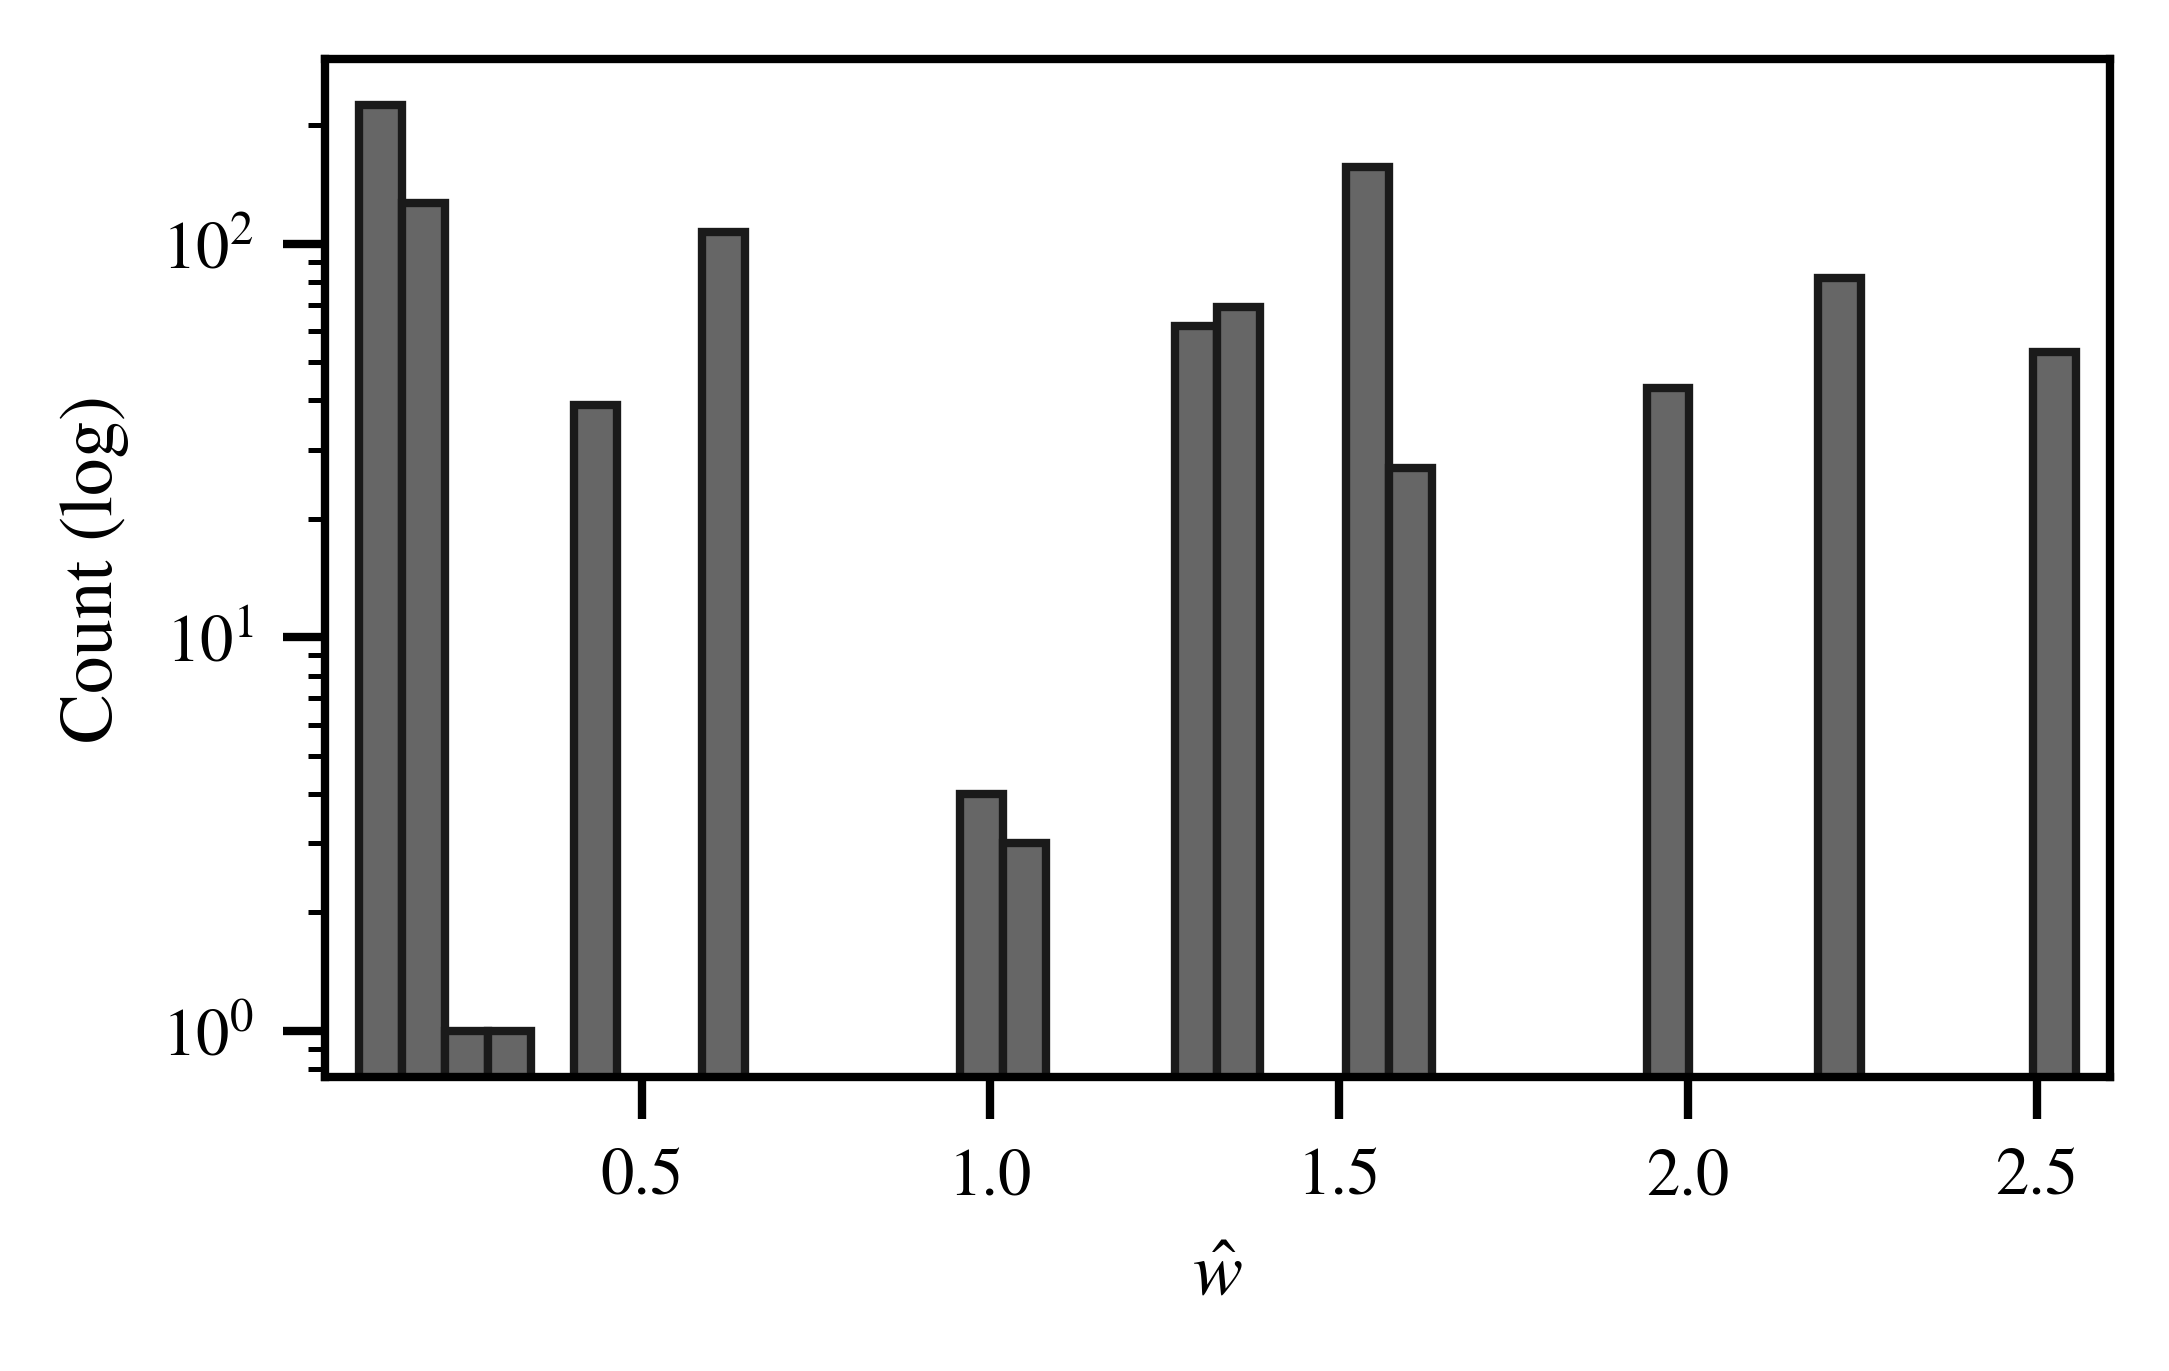

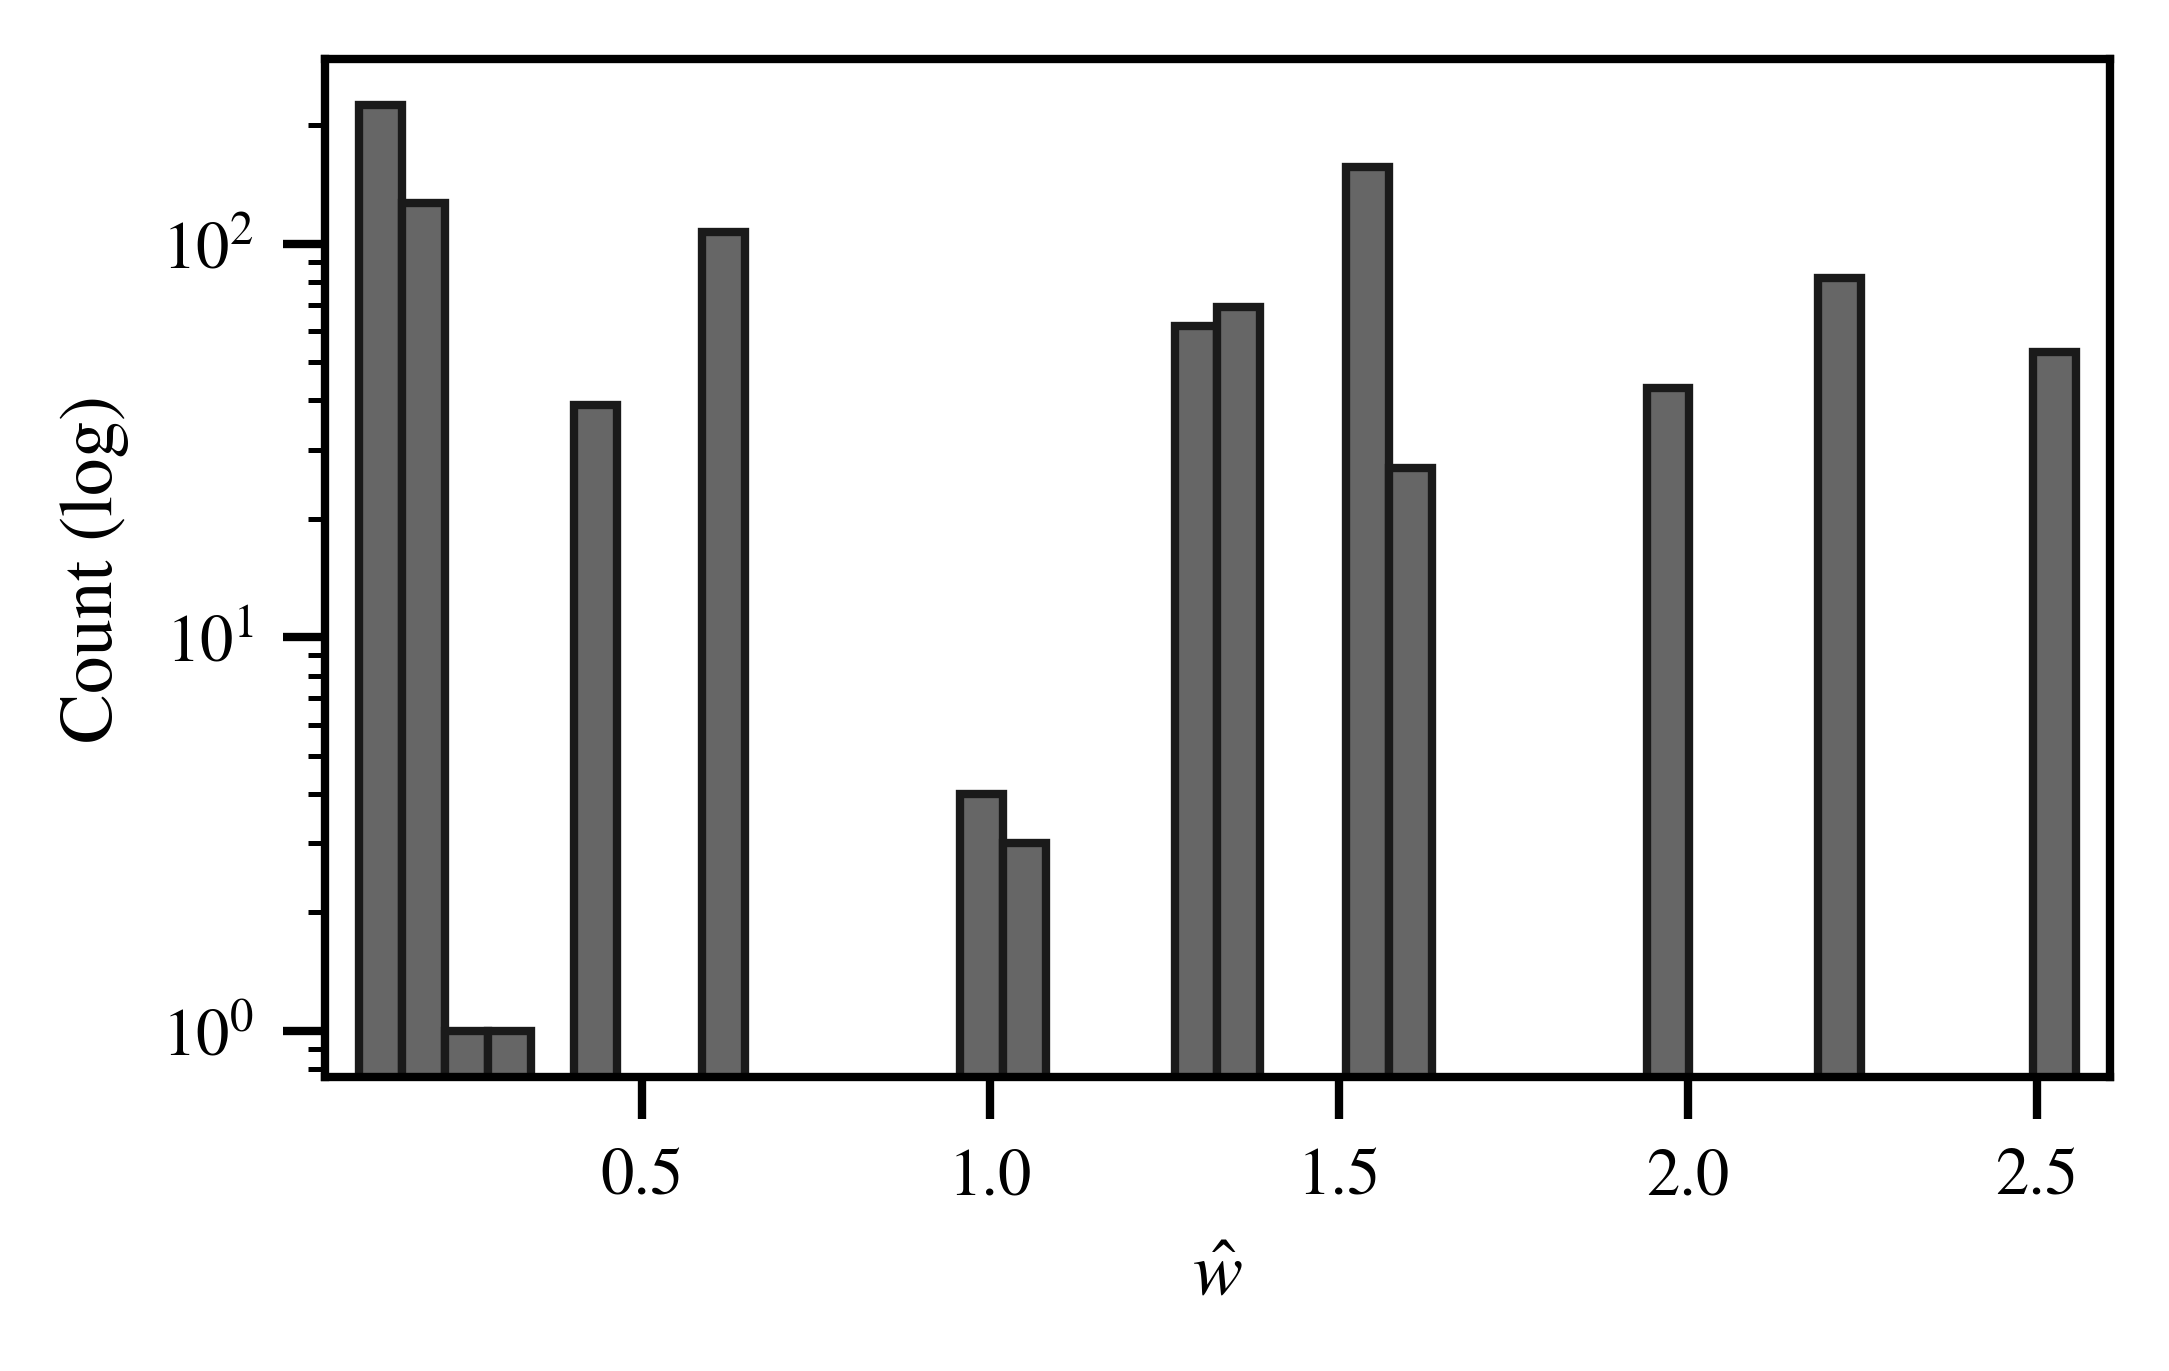

In [11]:
weights = (
    benchmark.target_policy.action_prob(dataset.contexts, dataset.actions)
    / dataset.behavior_action_probs
)
fig_weights = report.plot_importance_weights(weights, logy=True)
fig_weights

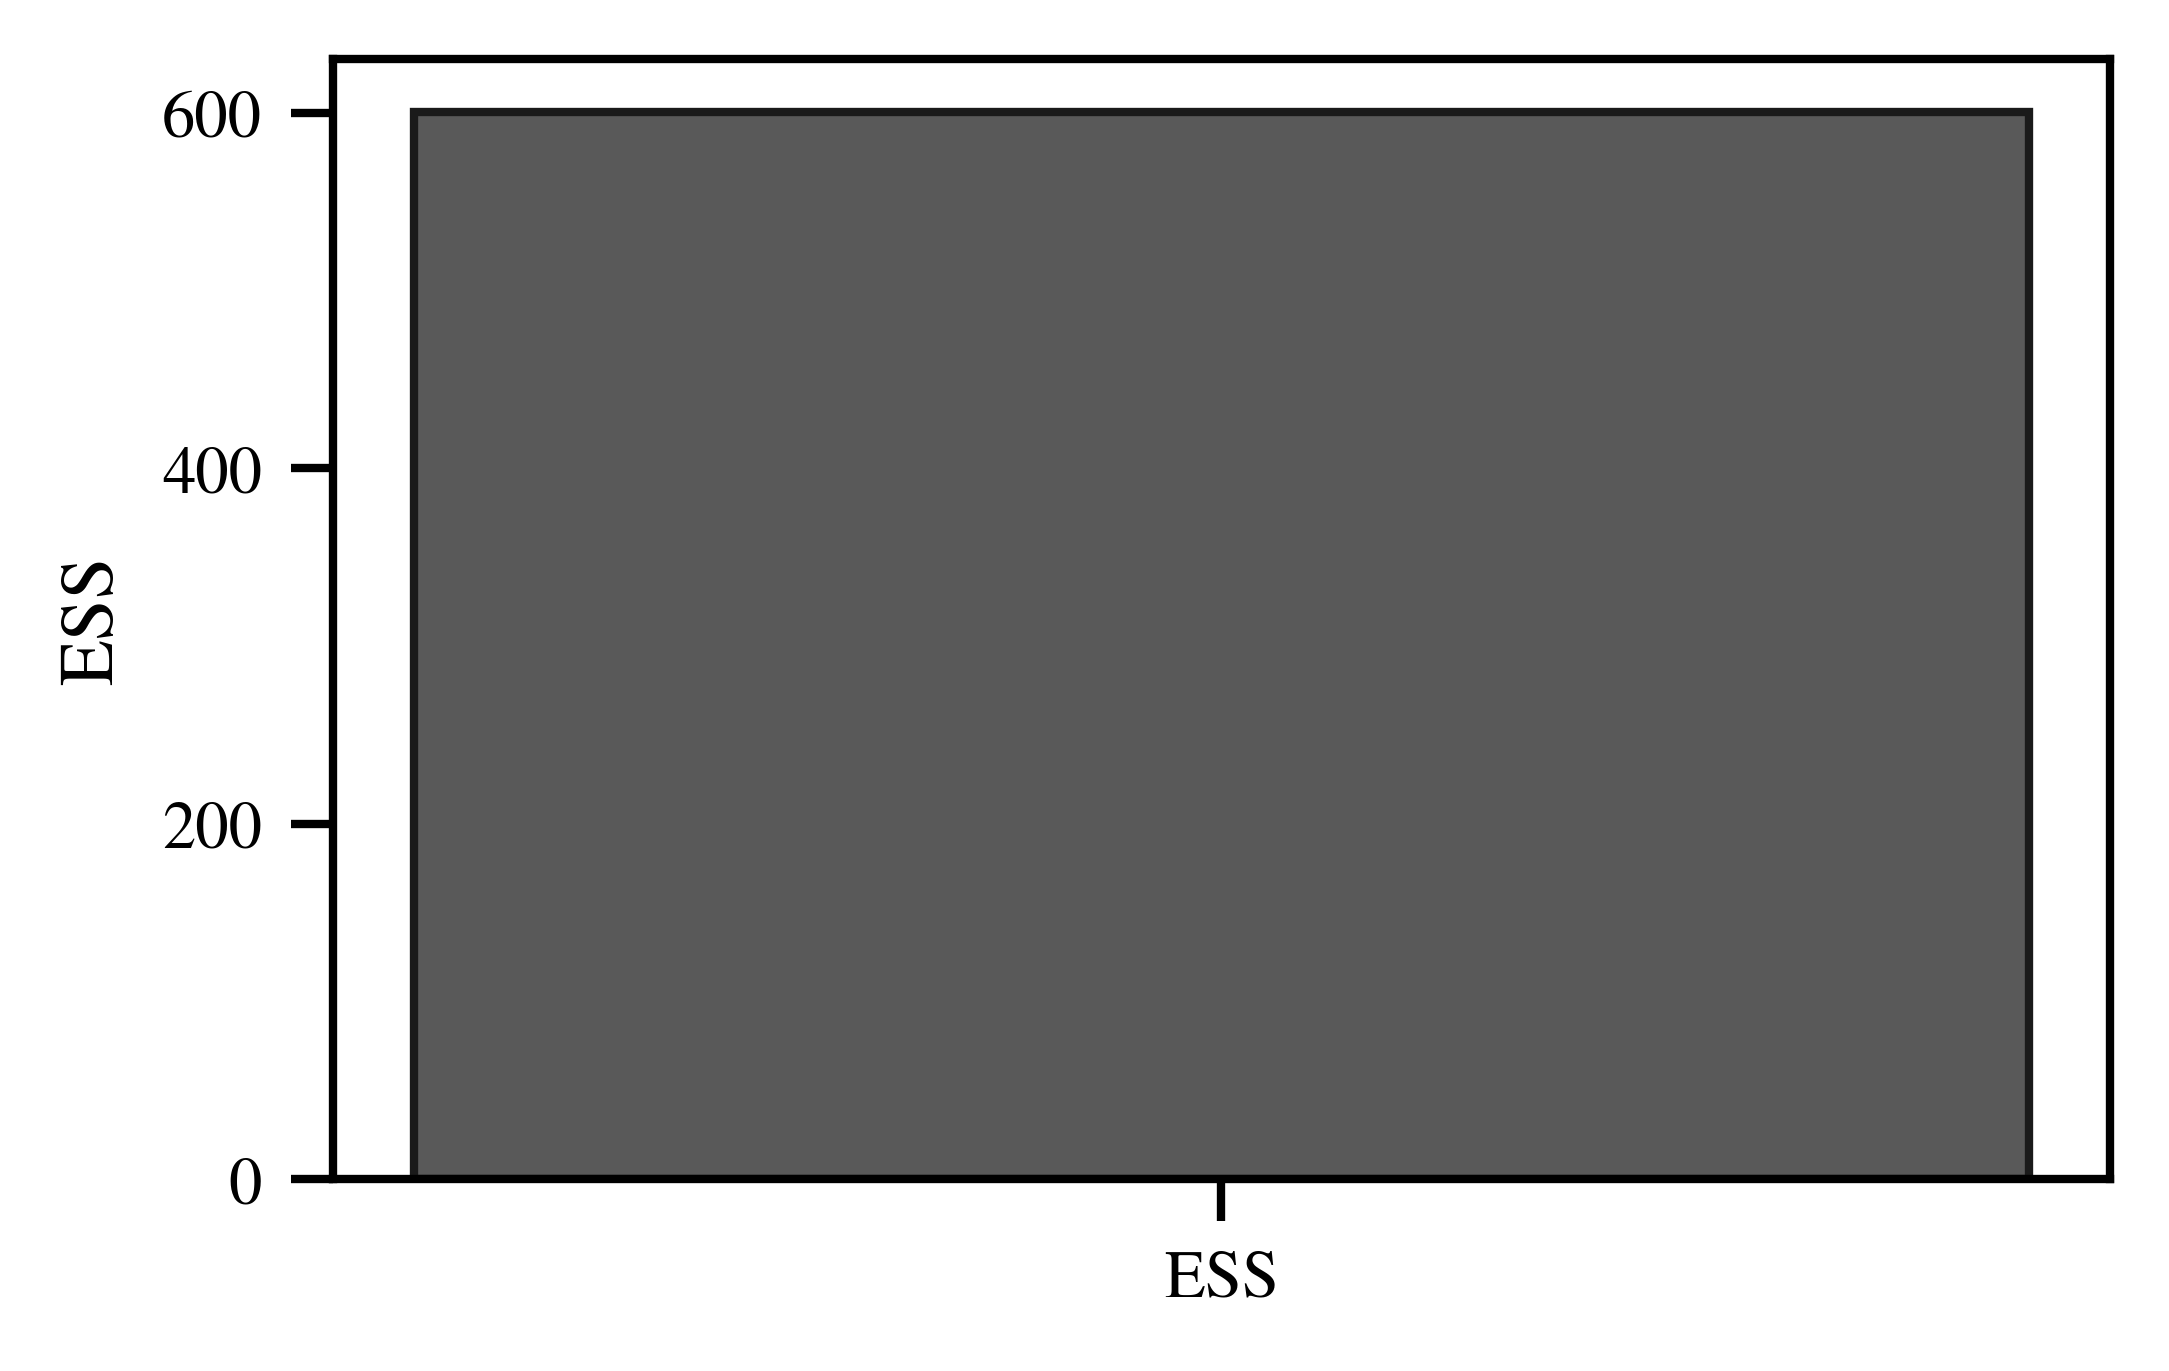

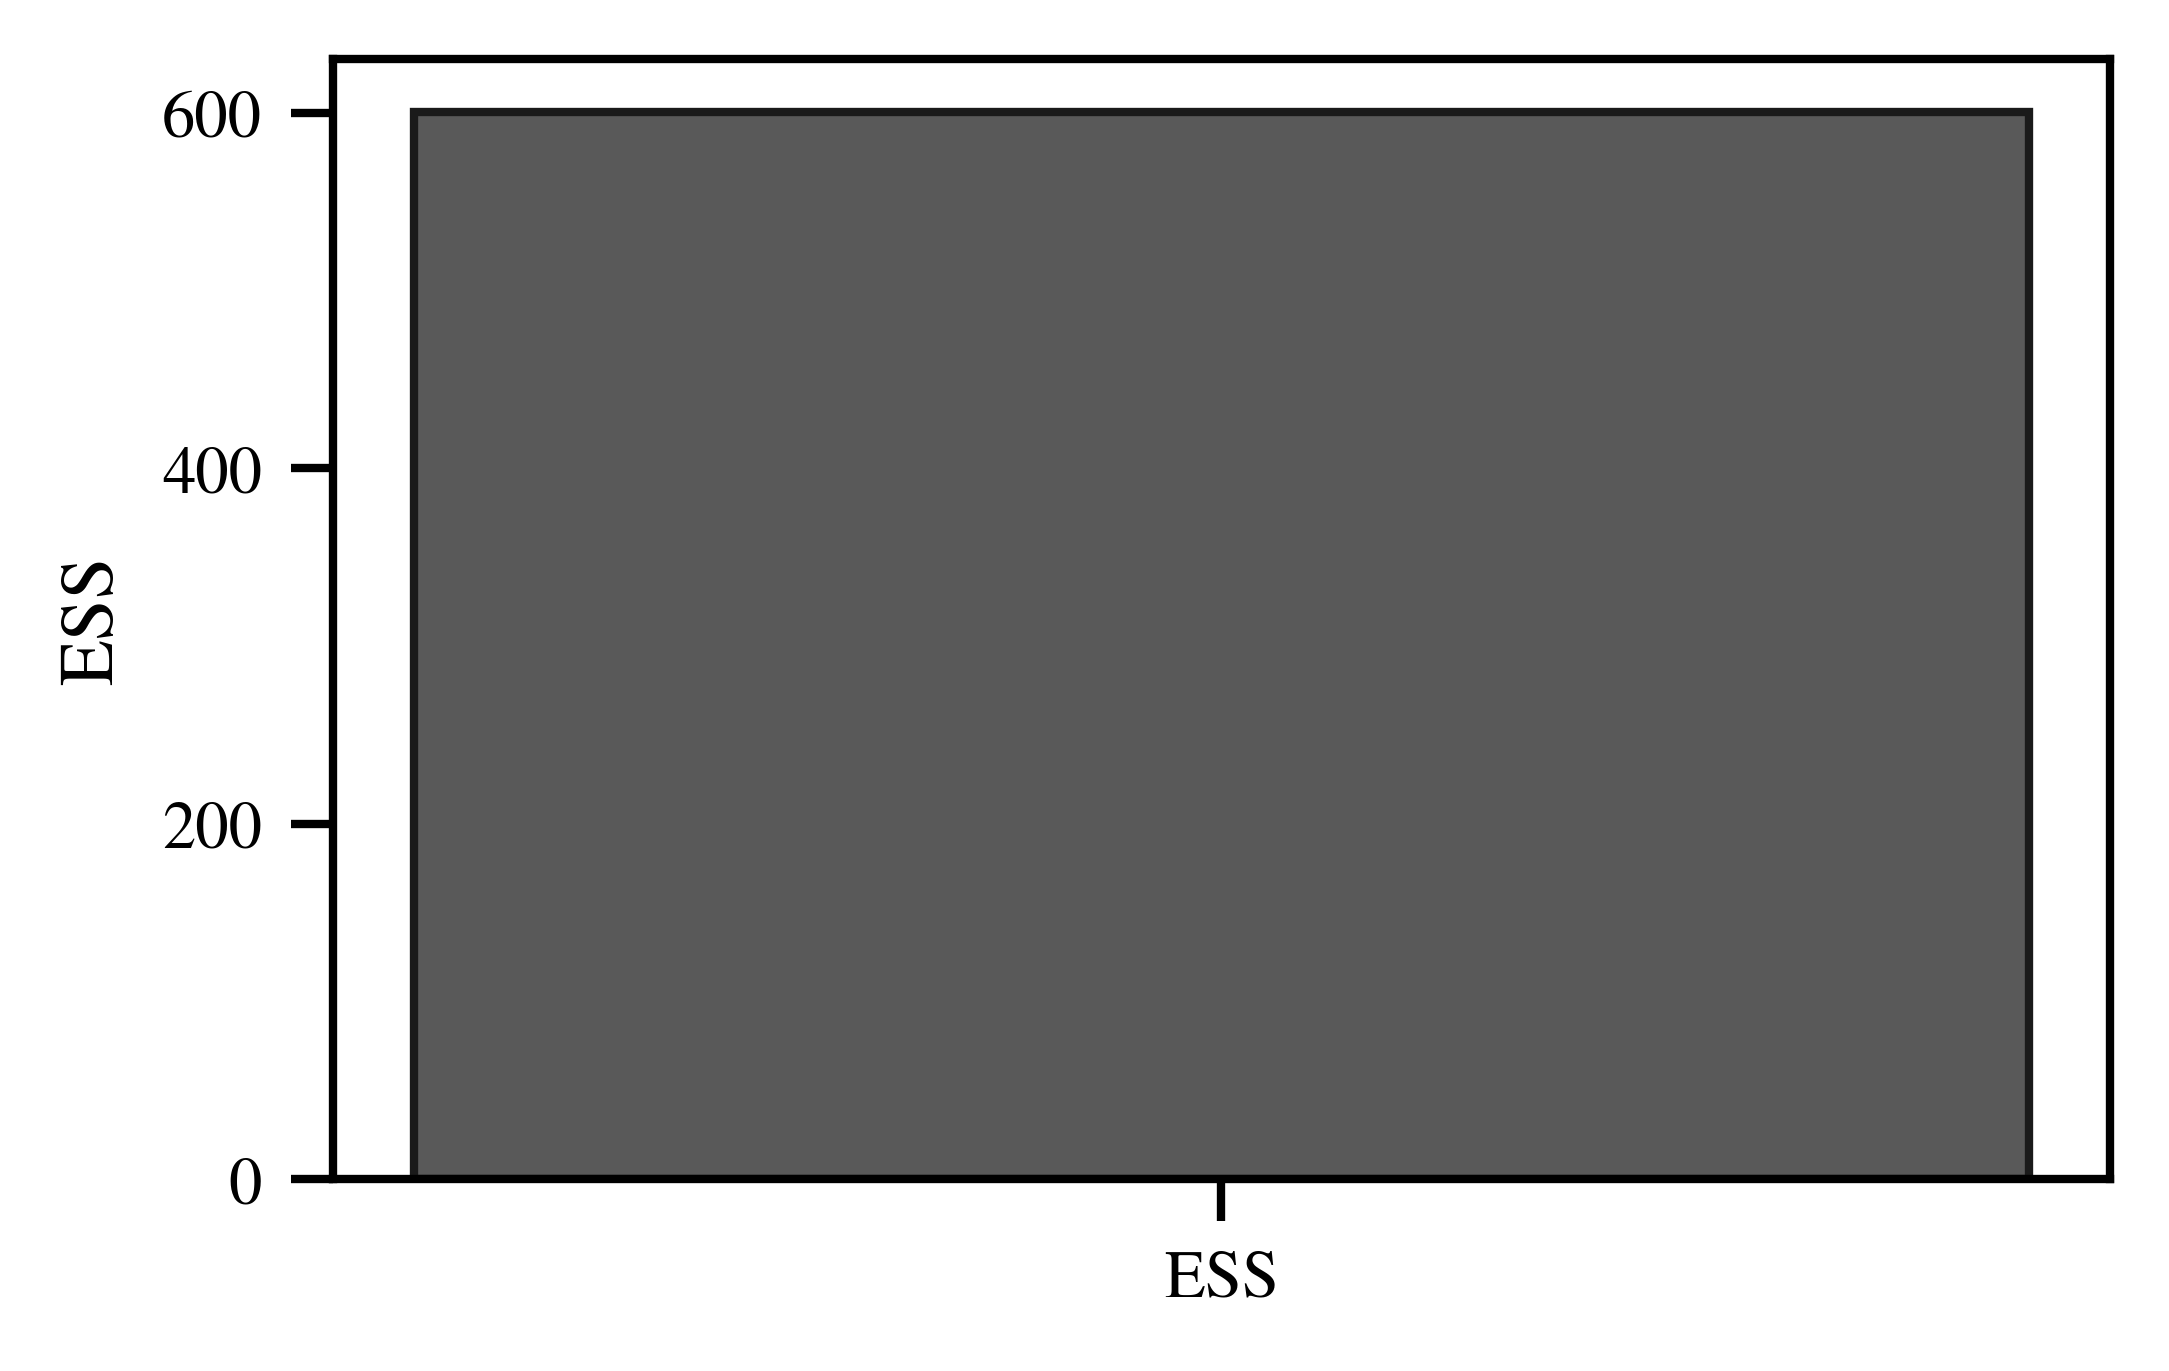

In [12]:
fig_ess = report.plot_effective_sample_size(weights, by_time=False)
fig_ess

## Report schema and HTML export

Every estimator returns the same schema: point estimate, uncertainty
(stderr/CI), diagnostics, and assumption flags. This makes it easy to compare
methods side-by-side and to automate downstream checks.

In [13]:
output_dir = Path("docs/assets/reports")
output_dir.mkdir(parents=True, exist_ok=True)
report_path = output_dir / "intro_bandit_report.html"
report.save_html(str(report_path))
report_path

PosixPath('docs/assets/reports/intro_bandit_report.html')

## Benchmarks and experiment runners

The benchmark harness runs synthetic bandit and MDP suites with known ground
truth. Experiment helpers write CSV/JSONL outputs and aggregate tables.

In [14]:
bandit_results = run_bandit_benchmark(num_samples=300, seed=0)
mdp_results = run_mdp_benchmark(num_trajectories=80, seed=0)
all_results = run_all_benchmarks(num_samples=300, num_trajectories=80, seed=0)

pd.DataFrame(all_results)

,benchmark,estimator,estimate,stderr,true_value,error
0,synthetic_bandit,IS,-0.379680,0.069728,-0.475036,0.095355
1,synthetic_bandit,WIS,-0.389021,0.079802,-0.475036,0.086015
2,synthetic_mdp,IS,-3.417238,3.964153,0.950605,-4.367843
3,synthetic_mdp,WIS,-1.281855,1.058580,0.950605,-2.232460
4,synthetic_mdp,PDIS,0.202710,0.630469,0.950605,-0.747896
5,synthetic_mdp,DR,0.329793,1.147775,0.950605,-0.620812
6,synthetic_mdp,FQE,1.181325,0.050942,0.950605,0.230720


In [15]:
bench_out = Path("docs/assets/benchmarks/intro")
bench_out.mkdir(parents=True, exist_ok=True)
bench_records = run_benchmarks_to_table(
    output_dir=bench_out, num_samples=200, num_trajectories=60, seed=0
)

pd.DataFrame(bench_records).head()

,benchmark,estimator,estimate,stderr,true_value,error
0,synthetic_bandit,IS,-0.484015,0.085121,-0.475036,-0.008979
1,synthetic_bandit,WIS,-0.471602,0.091629,-0.475036,0.003434
2,synthetic_mdp,IS,-4.813504,5.258441,0.950605,-5.764109
3,synthetic_mdp,WIS,-1.525416,0.934258,0.950605,-2.476021
4,synthetic_mdp,PDIS,0.122843,0.830917,0.950605,-0.827762


,suite,benchmark,type,estimator,estimate,stderr,true_value,error,seed,behavior_known
0,intro_demo,bandit_tiny,bandit,IS,-0.484015,0.085121,-0.475036,-0.008979,0,True
1,intro_demo,bandit_tiny,bandit,WIS,-0.471602,0.091629,-0.475036,0.003434,0,True


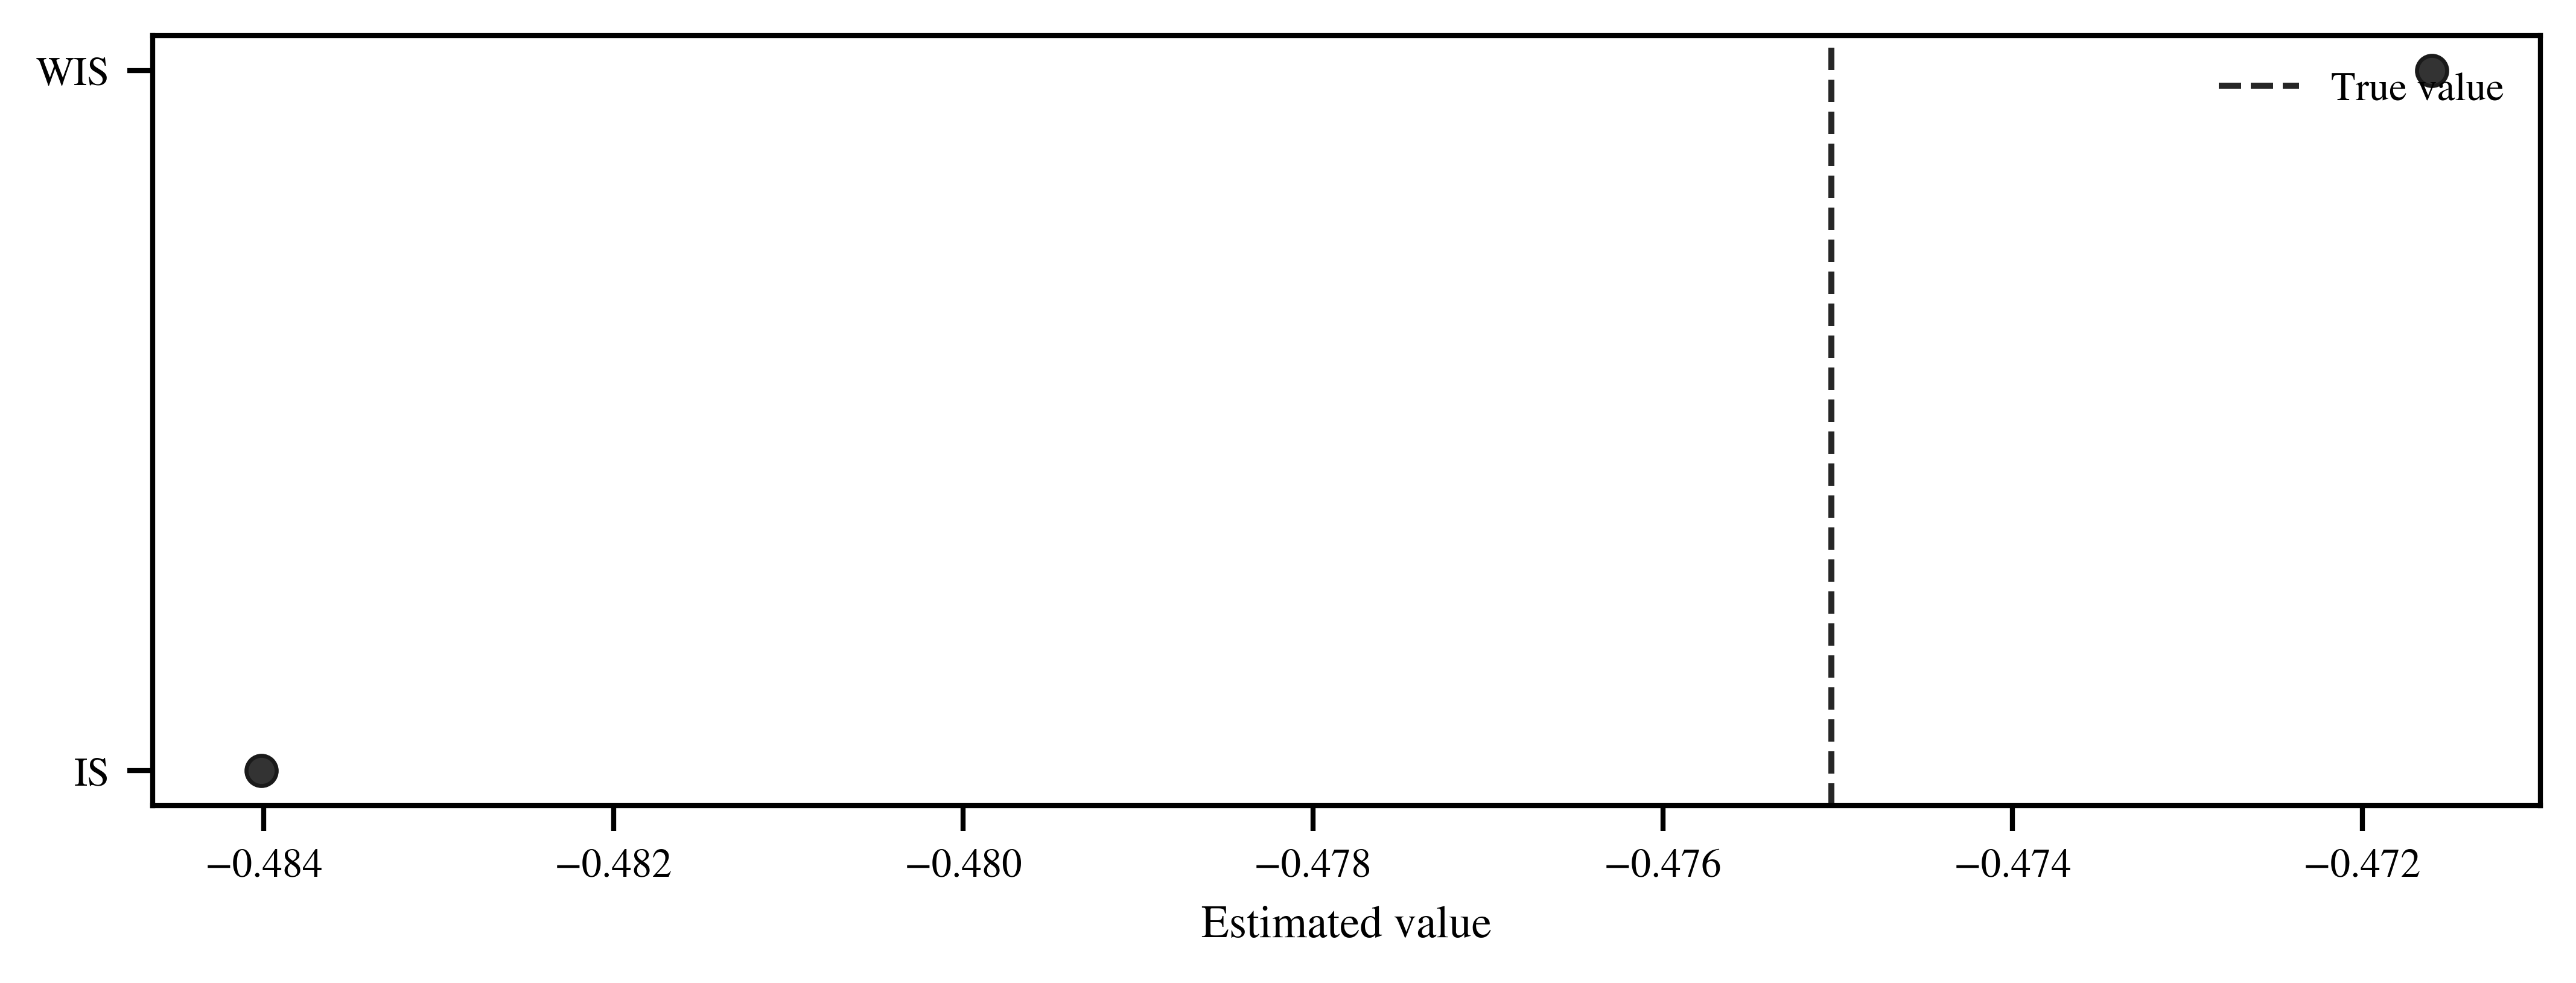

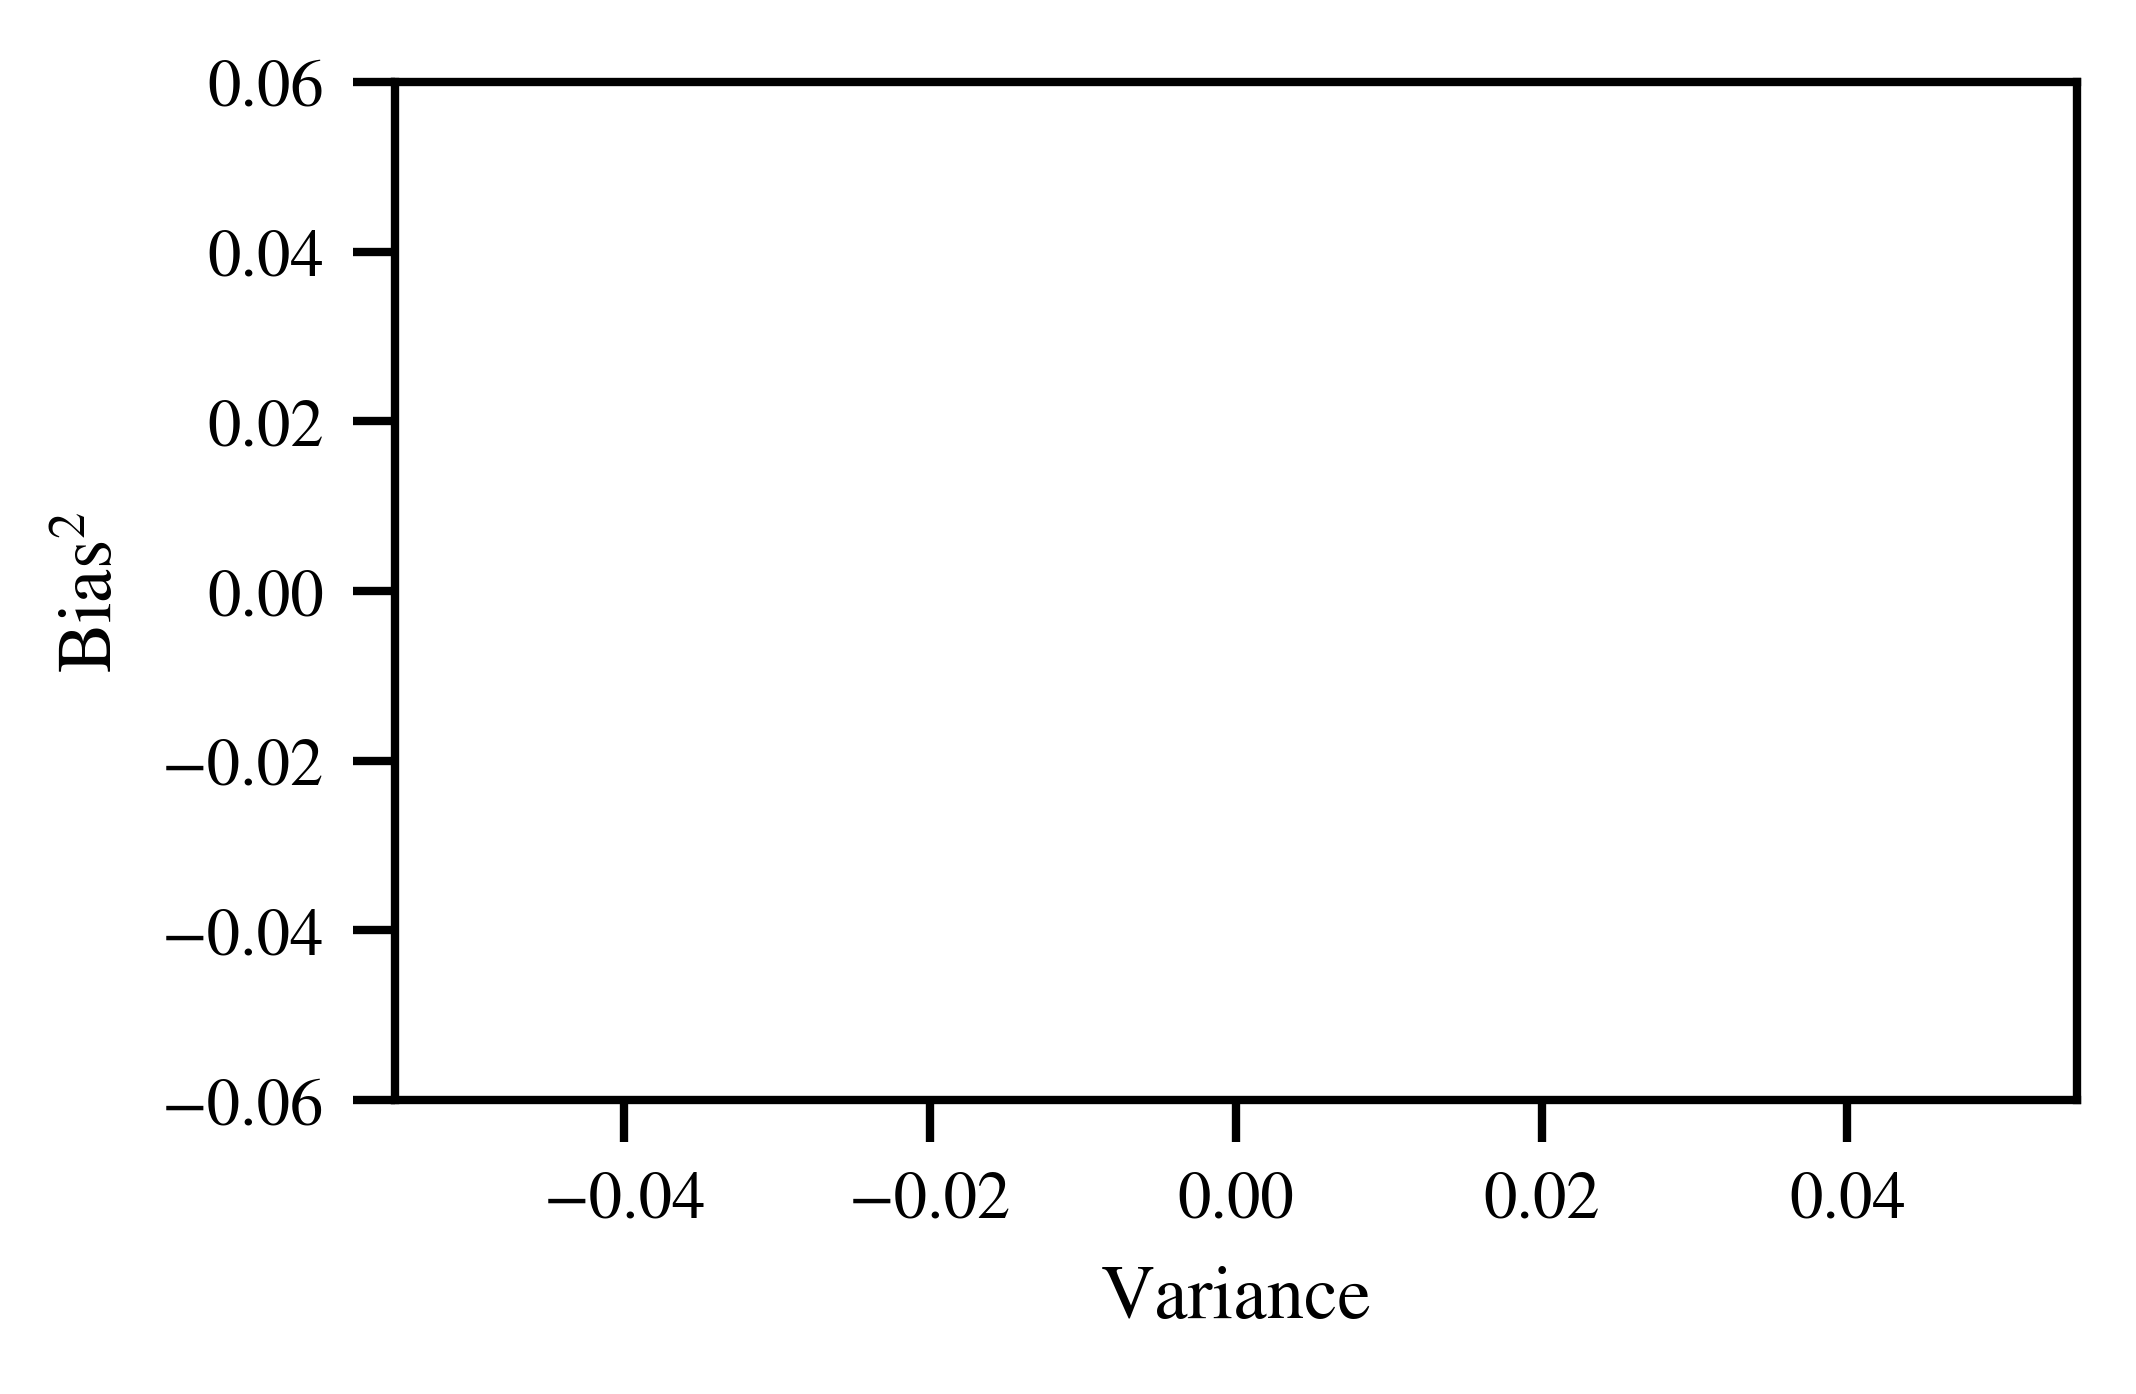

In [16]:
# A tiny custom suite to exercise run_benchmark_suite without long runtimes.
custom_suite_dir = bench_out / "suite_configs"
custom_suite_dir.mkdir(parents=True, exist_ok=True)
custom_suite = {
    "suite": "intro_demo",
    "benchmarks": [
        {
            "name": "bandit_tiny",
            "type": "bandit",
            "num_samples": 200,
            "estimators": ["is", "wis"],
            "behavior_known": True,
        }
    ],
}
(custom_suite_dir / "intro_demo.yaml").write_text(
    yaml.safe_dump(custom_suite), encoding="utf-8"
)

suite_df = run_benchmark_suite(
    suite="intro_demo",
    output_dir=bench_out / "suite_run",
    seeds=[0],
    config_dir=custom_suite_dir,
)

suite_df.head()

## Takeaways

- Policies, data contracts, and estimands form the backbone of OPE workflows.
- Reports standardize metrics, diagnostics, and figures across estimators.
- Benchmarks and experiment runners provide reproducible comparisons.
- HTML export creates shareable artifacts for reviews.